In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2100_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2100_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 1165
inactives: 291883


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=300, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=300, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

In [5]:
df = pd.concat([actives_train, inactives_train[:1000]], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,2,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,4.858,0.269000,0.522,2.83900,1
1,1,0,0,0,2,0,0,0,0,0,...,0,0,1,0,0,4.700,-0.750000,0.273,2.09400,1
2,2,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.000,-0.716962,0.500,3.36851,0
3,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.248,0.235000,0.414,2.23900,1
4,1,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,4.907,-0.729000,0.240,1.09800,1


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

0    1000
1     865
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

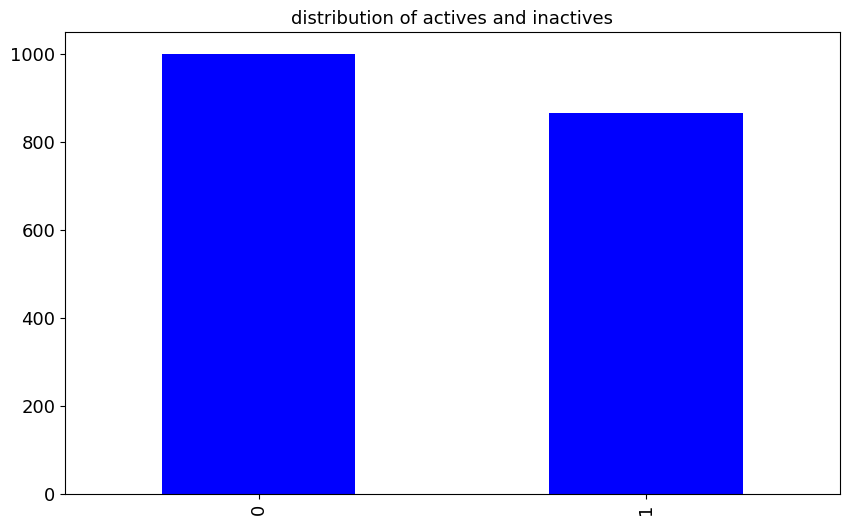

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [13]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validatee = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((1846, 606), (19, 777))

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

0    987
1    987
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

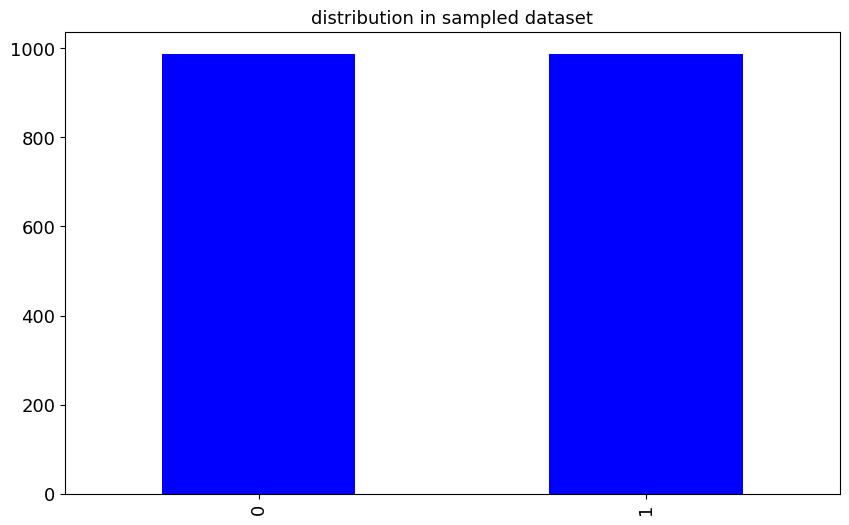

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
model = RandomForestClassifier(random_state=42, verbose=1, class_weight={0: 1, 1: 1.15}, n_jobs=-1)
model.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomForestClassifier(class_weight={0: 1, 1: 1.15}, n_jobs=-1, random_state=42,
                       verbose=1)

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

600

In [20]:
testing_data['activity'].value_counts()

1    300
0    300
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,5.087,0.343,0.240,0.314,1
1,0,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.087,-0.684,0.000,1.682,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.129,0.301,0.462,2.812,1
3,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.129,-0.323,0.231,1.792,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,5.000,-0.323,0.480,2.594,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

600


In [23]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [24]:
testing_data_x = testing_data_x.loc[:, mask]

In [25]:
testing_data_x.head()

,D001,D002,D003,D004,D005,D006,D007,D010,D012,D013,...,D764,D765,D768,D770,D771,D773,D774,D775,D776,D777
0,-0.665522,-0.065974,-0.032933,-1.025267,-0.254930,-0.124103,-0.040346,-0.023281,-0.397846,-0.943168,...,-0.126334,0.796560,-0.165699,1.143663,-0.259826,-0.065974,0.073834,0.904982,-0.654221,-1.437113
1,-2.026047,-0.065974,-0.032933,-1.025267,0.804981,-0.124103,-0.040346,-0.023281,-1.622702,1.214314,...,-0.126334,1.884976,-0.165699,1.143663,-0.259826,-0.065974,0.073834,-0.547240,-2.258866,-0.343127
2,0.695003,-0.065974,-0.032933,0.330494,-0.254930,-0.124103,-0.040346,-0.023281,0.582039,-0.403798,...,-0.126334,-1.380272,-0.165699,-0.639447,-0.259826,-0.065974,0.179872,0.845592,0.830074,0.560530
3,-0.665522,-0.065974,-0.032933,1.686256,-0.254930,-0.124103,-0.040346,-0.023281,-0.152875,0.674944,...,-0.126334,-0.291856,-0.165699,-0.639447,-0.259826,-0.065974,0.179872,-0.036770,-0.714396,-0.255161
4,0.695003,-0.065974,-0.032933,-1.025267,0.804981,-0.124103,-0.040346,-0.023281,0.092096,-0.403798,...,-0.126334,-1.380272,-0.165699,-0.639447,3.401539,-0.065974,-0.145816,-0.036770,0.950423,0.386196


In [26]:
model.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([1], dtype=int64)

In [27]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [28]:
model.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7333333333333333

### evaluating model's performance with F1 score, precision, recall, etc

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
y_pred = model.predict_proba(testing_data_x)[:, 1]
y_pred_rounded = (y_pred > 0.5).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


True

In [31]:
testing_data_y.shape == y_pred.shape

True

In [32]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [33]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.7333333333333333
precision is 0.6598173515981736
recall is 0.9633333333333334
f1 is 0.7831978319783198
